In [1]:
from copy import copy
from itertools import combinations

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import warnings

from scipy.stats import mannwhitneyu

sns.set_theme()
warnings.filterwarnings('ignore')

In [2]:
problems = ["chemical_1_tower", "chemical_2_competition", "friction_dyn_one-hot", "friction_stat_one-hot",
            "nasa_battery_1_10min", "nasa_battery_2_20min", "nikuradse_1", "nikuradse_2", "flow_stress_phip0.1", ]

In [3]:
dfs = []
missing = 0
missing_configs = []
for w in ["win", "wfn", "win_bin", "wfn_bin", "win_bfn", "wfn_bfn", "no"]:
    for problem in problems:
        for seed in range(30):
            for opt in ["adam", "gaussian"]:
                w_text = f"{w}_" if "w" in w else ""
                if os.path.exists(f"../results/ga2_{problem}_{opt}_{w_text}{seed}.pickle"):
                    tmp_df = pd.read_csv(f"../results/ga2_{problem}_{opt}_{w_text}{seed}.csv")
                    tmp_df["seed"] = seed
                    tmp_df["w"] = w
                    tmp_df["opt"] = opt
                    tmp_df["problem"] = problem
                    tmp_df["total_time"] = tmp_df["time"].cumsum().astype(int)
                    dfs.append(tmp_df)
                else:
                    if "w" in w:
                        missing += 1
                        print(problem, w, seed)
                        missing_configs.append([seed, w, problem])
                    continue
df = pd.concat(dfs, ignore_index=True)
df["test_accuracy"] = df["test_accuracy"].str.replace(r"[\[\]]", "", regex=True).astype(float)
df.head()

,iteration,max_fitness,time,test_accuracy,seed,w,opt,problem,total_time
0,0,-3.591574,0.000000,-4.37319,0,win,adam,chemical_1_tower,0
1,1,-3.345382,16.725472,-4.37319,0,win,adam,chemical_1_tower,16
2,2,-3.046887,16.692033,-4.37319,0,win,adam,chemical_1_tower,33
3,3,-3.509441,16.876105,-4.37319,0,win,adam,chemical_1_tower,50
4,4,-3.620439,16.455559,-4.37319,0,win,adam,chemical_1_tower,66


In [4]:
max_iter = (
    df.groupby(["problem", "opt"])["iteration"]
    .max()
    .unstack()
)
max_iter["adam_iteration_multiplier"] = max_iter["gaussian"] / max_iter["adam"]
result = max_iter.reset_index()
df = df.merge(
    result[["problem", "adam_iteration_multiplier"]],
    on="problem",
    how="left"
)
df["adjusted_iteration"] = np.where(
    df["opt"] == "adam",
    df["iteration"] * df["adam_iteration_multiplier"],
    df["iteration"]
)
df.head()

,iteration,max_fitness,time,test_accuracy,seed,w,opt,problem,total_time,adam_iteration_multiplier,adjusted_iteration
0,0,-3.591574,0.000000,-4.37319,0,win,adam,chemical_1_tower,0,2.566781,0.000000
1,1,-3.345382,16.725472,-4.37319,0,win,adam,chemical_1_tower,16,2.566781,2.566781
2,2,-3.046887,16.692033,-4.37319,0,win,adam,chemical_1_tower,33,2.566781,5.133562
3,3,-3.509441,16.876105,-4.37319,0,win,adam,chemical_1_tower,50,2.566781,7.700342
4,4,-3.620439,16.455559,-4.37319,0,win,adam,chemical_1_tower,66,2.566781,10.267123


In [5]:
baselines_list = ["Operon", "QLattice", "PySR", "eggp"]
# baselines_list = ["Operon"]
baselines_df = pd.read_csv("baselines.csv")
baselines_df.rename(columns={
    "run": "seed",
    "algorithm": "opt",
    "r2_test": "accuracy",
    "dataset": "problem",
}, inplace=True)
baselines_df = baselines_df[["seed", "opt", "accuracy", "problem"]]
baselines_df = baselines_df[baselines_df["opt"].isin(baselines_list)]
baselines_df = baselines_df[baselines_df["problem"].isin(problems)]
baselines_df["w"] = "no"
baselines_df.head()

,seed,opt,accuracy,problem,w
4696,0,eggp,0.876939,chemical_1_tower,no
4697,1,eggp,0.857567,chemical_1_tower,no
4698,2,eggp,0.868668,chemical_1_tower,no
4699,3,eggp,0.829023,chemical_1_tower,no
4700,4,eggp,0.840139,chemical_1_tower,no


In [6]:
df1 = copy(df)
df2 = copy(df)
df1 = df.rename(columns={"test_accuracy": "accuracy"})
df2 = df.rename(columns={"max_fitness": "accuracy"})
df1 = df1.drop(columns=["max_fitness"])
df2 = df2.drop(columns=["test_accuracy"])
df1["when"] = "test"
df2["when"] = "train"
df = pd.concat([df1, df2], ignore_index=True)
df.head()

,iteration,time,accuracy,seed,w,opt,problem,total_time,adam_iteration_multiplier,adjusted_iteration,when
0,0,0.000000,-4.37319,0,win,adam,chemical_1_tower,0,2.566781,0.000000,test
1,1,16.725472,-4.37319,0,win,adam,chemical_1_tower,16,2.566781,2.566781,test
2,2,16.692033,-4.37319,0,win,adam,chemical_1_tower,33,2.566781,5.133562,test
3,3,16.876105,-4.37319,0,win,adam,chemical_1_tower,50,2.566781,7.700342,test
4,4,16.455559,-4.37319,0,win,adam,chemical_1_tower,66,2.566781,10.267123,test


In [7]:
max_iter = df.groupby(["opt", "problem"])["iteration"].transform("max")
final_df = df[df["iteration"] == max_iter].reset_index(drop=True)
final_df.head()

,iteration,time,accuracy,seed,w,opt,problem,total_time,adam_iteration_multiplier,adjusted_iteration,when
0,584,16.919471,0.839344,0,win,adam,chemical_1_tower,9959,2.566781,1499.0,test
1,1499,2.746425,0.489220,0,win,gaussian,chemical_1_tower,4298,2.566781,1499.0,test
2,584,17.071883,0.674324,1,win,adam,chemical_1_tower,9924,2.566781,1499.0,test
3,1499,2.771516,0.802236,1,win,gaussian,chemical_1_tower,4285,2.566781,1499.0,test
4,584,16.854705,0.812983,2,win,adam,chemical_1_tower,9885,2.566781,1499.0,test


In [8]:
reopt_dfs = []
missing = 0
for w in ["win", "wfn", "win_bin", "wfn_bin", "win_bfn", "wfn_bfn", "no"]:
    for problem in problems:
        for seed in range(30):
            for reopt in ["adam", ]:
                for opt in ["adam", "gaussian", "none"]:
                    try:
                        tmp_df = pd.read_csv(f"../results/ga3_{problem}_{opt}_{w}_reopt-{reopt}_{seed}.csv")
                        tmp_df["seed"] = seed
                        tmp_df["w"] = w if len(w) > 0 else "no w"
                        tmp_df["opt"] = opt if opt != "none" else "CGP"
                        tmp_df["reopt"] = reopt
                        tmp_df["problem"] = problem
                        reopt_dfs.append(tmp_df)
                    except FileNotFoundError:
                        if "w" in w:
                            missing += 1
                        pass
reopt_df = pd.concat(reopt_dfs, ignore_index=True)
reopt_df["test_increase"] = reopt_df["test_accuracy"] - reopt_df["previous_test_accuracy"]
reopt_df["train_increase"] = reopt_df["max_fitness"] - reopt_df["previous_max_fitness"]
reopt_df["equation"] = reopt_df["equation"].str.replace("<lambda>", "", regex=False)
reopt_df.head()

,iteration,time,max_fitness,test_accuracy,previous_max_fitness,previous_test_accuracy,equation,seed,w,opt,reopt,problem,test_increase,train_increase
0,0,194.660743,0.839458,0.839344,0.839458,0.839344,o0 = ((-0.97*(-0.27*(0.04*(0.17*i1*0.40*i21)-0...,0,win,adam,adam,chemical_1_tower,0.000000,0.000000
1,0,119.438212,0.472530,0.487041,0.472454,0.485554,o0 = ((-0.42*(0.61*abs(-1.47*i21)-0.11*i5)--1....,0,win,gaussian,adam,chemical_1_tower,0.001487,0.000075
2,0,154.413757,0.608548,0.622315,0.592760,0.607127,o0 = ((1.03*sqrt(1.03*pow(1.04*i9))+1.02*(0.99...,0,win,CGP,adam,chemical_1_tower,0.015188,0.015787
3,0,194.586228,0.667210,0.675796,0.667259,0.673817,o0 = ((-0.31*(-0.59*(0.50*(0.40*i1--1.15*i20)-...,1,win,adam,adam,chemical_1_tower,0.001980,-0.000049
4,0,119.870111,0.792544,0.801759,0.793436,0.802236,o0 = (abs(1.57*(0.94*(0.76*sqrt(-0.73*(-1.81*i...,1,win,gaussian,adam,chemical_1_tower,-0.000477,-0.000892


In [ ]:
# reopt_df.drop(columns=['iteration']).to_csv("equations.csv")

In [ ]:
k = 50  # keep one point every 10 iterations

df_plot = (
    df[(df["when"] == "train") & (df["w"].isin(["no", "win", "wfn"]))]
    .assign(iter_bin=lambda d: d["adjusted_iteration"] // k * k)
    .groupby(["problem", "opt", "w", "iter_bin"], as_index=False)
    .accuracy.mean()
    .rename(columns={"iter_bin": "adjusted_iteration"})
)
df_plot.loc[df_plot["w"] == "no", "opt"] = "CGP"

sns.relplot(data=df_plot, x="adjusted_iteration", y="accuracy", hue="opt", col_wrap=3,
            col="problem", errorbar=None, style="w", kind="line", palette="Set1")
plt.ylim(-.1, 1.1)
plt.show()

In [ ]:
# sns.relplot(data=df[df["when"] == "test"], x="adjusted_iteration", y="accuracy", hue="opt", col="w",
#             row="problem", errorbar="sd", kind="line", palette="Set1")
# plt.ylim(-.1, 1.1)
# plt.show()

In [ ]:
sns.catplot(x="w", y="accuracy", hue="opt", data=final_df[final_df["when"] == "train"], col_wrap=5,  # row="when",
            col="problem", kind="box", palette="Set1")
plt.ylim(-.3, 1.1)
plt.show()

In [9]:
final_df_for_baseline_merge = final_df[final_df["when"] == "test"][["seed", "w", "opt", "problem", "accuracy"]]
baselines_df_filtered = baselines_df[baselines_df["problem"].isin(final_df_for_baseline_merge["problem"])]
final_df_and_baseline = pd.concat([final_df_for_baseline_merge, baselines_df_filtered], ignore_index=True)
final_df_and_baseline.head()

,seed,w,opt,problem,accuracy
0,0,win,adam,chemical_1_tower,0.839344
1,0,win,gaussian,chemical_1_tower,0.489220
2,1,win,adam,chemical_1_tower,0.674324
3,1,win,gaussian,chemical_1_tower,0.802236
4,2,win,adam,chemical_1_tower,0.812983


In [10]:
reopt_df_for_baseline_merge = reopt_df[["seed", "w", "opt", "reopt", "problem", "test_accuracy"]]
reopt_df_for_baseline_merge.rename(columns={"test_accuracy": "accuracy"}, inplace=True)
# baselines_df.rename(columns={"opt": "reopt"}, inplace=True)
baselines_df["reopt"] = "none"
final_df_and_baseline.loc[
    (final_df_and_baseline["w"] == "no") & (final_df_and_baseline["opt"] == "gaussian"),
    "opt"
] = "CGP"
reopt_df_and_baseline = pd.concat([reopt_df_for_baseline_merge, baselines_df], ignore_index=True)

In [ ]:
g = sns.catplot(x="w", y="accuracy", hue="opt", data=final_df_and_baseline, col="problem", col_wrap=3,
                kind="box", palette="Set1", height=3, aspect=2)
g.figure.suptitle("$R^2$ score on test set, end of evolution", y=1.05)  # Add title above the plot
plt.ylim(-.3, 1.1)
plt.show()

In [ ]:
# g = sns.catplot(data=reopt_df, x="w", y="max_fitness", hue="opt", col="problem", kind="box", palette="Set1", col_wrap=5)
# plt.ylim(-.3, 1.1)
# plt.show()

In [ ]:
# sns.catplot(data=reopt_df, x="w", y="test_accuracy", hue="opt", col="problem", kind="box", palette="Set1", col_wrap=5)
# plt.ylim(-.3, 1.1)
# plt.show()

In [ ]:
g = sns.catplot(data=reopt_df_and_baseline, x="w", y="accuracy", hue="opt", col="problem", kind="box", palette="Set1",
                col_wrap=3, height=3, aspect=2)
g.figure.suptitle("$R^2$ on test set after the re-optimization of constants",
                  y=1.05)  # Add title above the plot
plt.ylim(-.3, 1.1)
plt.show()

In [11]:
fb_final = final_df_and_baseline.copy()
fb_final["reopt"] = "N"
reopt_df_for_baseline_merge["reopt"] = "Y"
super_final_df = pd.concat([fb_final, reopt_df_for_baseline_merge], ignore_index=True)
super_final_df["w_reopt"] = super_final_df["w"].astype(str) + " " + super_final_df["reopt"].astype(str)
w_order = sorted(super_final_df["w"].unique())
reopt_order = sorted(super_final_df["reopt"].unique())
combined_order = [f"{w} {r}" for w in w_order for r in reopt_order if f"{w} {r}" in super_final_df["w_reopt"].values]
super_final_df["w_reopt"] = pd.Categorical(super_final_df["w_reopt"], categories=combined_order, ordered=True)
super_final_df.head()

,seed,w,opt,problem,accuracy,reopt,w_reopt
0,0,win,adam,chemical_1_tower,0.839344,N,win N
1,0,win,gaussian,chemical_1_tower,0.489220,N,win N
2,1,win,adam,chemical_1_tower,0.674324,N,win N
3,1,win,gaussian,chemical_1_tower,0.802236,N,win N
4,2,win,adam,chemical_1_tower,0.812983,N,win N


In [ ]:
g = sns.catplot(data=super_final_df, x="w_reopt", y="accuracy", hue="opt", col="problem", kind="box", palette="Set1",
                col_wrap=2, height=3, aspect=4, sharex=False, )
g.figure.suptitle(
    "Global results \n $x$ axis: weights/biases considered (none, fn on nodes, in on connections), constants re-optimization (N none, Y yes, with adam)",
    y=1.05)
plt.ylim(-.3, 1.1)
plt.show()

In [ ]:
final_df_fabricio = final_df.copy()
final_df_fabricio = final_df_fabricio.rename(columns={
    "accuracy": "r2",
    "seed": "run",
    "problem": "dataset"
})
final_df_fabricio["algorithm"] = final_df_fabricio["opt"].astype(str) + "_" + final_df_fabricio["w"].astype(str)
final_df_fabricio = final_df_fabricio[["run", "algorithm", "dataset", "r2", "when", ]]
final_df_fabricio_wide = (
    final_df_fabricio
    .pivot(
        index=[c for c in final_df_fabricio.columns if c not in ["when", "r2"]],
        columns="when",
        values="r2"
    )
    .reset_index()
    .rename(columns={
        "train": "r2_train",
        "test": "r2_test"
    })
)
final_df_fabricio_wide

In [ ]:
reopt_df_fabricio = reopt_df.copy()
reopt_df_fabricio = reopt_df_fabricio.rename(columns={
    "max_fitness": "r2_train",
    "test_accuracy": "r2_test",
    "seed": "run",
    "problem": "dataset"
})
reopt_df_fabricio["algorithm"] = reopt_df_fabricio["opt"].astype(str) + "_" + reopt_df_fabricio["w"].astype(
    str) + "_reopt"
reopt_df_fabricio = reopt_df_fabricio[["run", "algorithm", "dataset", "r2_test", "r2_train", ]]
reopt_df_fabricio

In [ ]:
df_fabricio = pd.concat([final_df_fabricio_wide, reopt_df_fabricio], ignore_index=True)
df_fabricio.to_csv("critical_diagram_results.csv", index=False)

In [ ]:
df_fabricio_non_add = df_fabricio[~df_fabricio["algorithm"].str.contains("bin|bfn", regex=True)]
df_fabricio_non_add['algorithm'] = df_fabricio_non_add['algorithm'].str.replace("adam", "SGD")
df_fabricio_non_add['algorithm'] = df_fabricio_non_add['algorithm'].str.replace("gaussian_no", "CGP")
df_fabricio_non_add['algorithm'] = df_fabricio_non_add['algorithm'].str.replace("gaussian", "Gaussian")
df_fabricio_non_add['algorithm'] = df_fabricio_non_add['algorithm'].str.replace("_reopt", " (re-opt.)")
df_fabricio_non_add['algorithm'] = df_fabricio_non_add['algorithm'].str.replace("_wfn", ", $w_\\text{node}$")
df_fabricio_non_add['algorithm'] = df_fabricio_non_add['algorithm'].str.replace("_win", ", $w_\\text{link}$")
df_fabricio_non_add.to_csv("critical_diagram_results_mult_only.csv", index=False)

In [12]:
median_final_df = \
    final_df_and_baseline[final_df_and_baseline["opt"].isin(["gaussian", "adam", "CGP"])].groupby(
        ['opt', 'w', 'problem'])['accuracy'].median().reset_index()
median_final_df = median_final_df.rename(columns={"accuracy": "median_accuracy"})
best_configs_final_df = median_final_df.loc[median_final_df.groupby(['problem', 'opt'])["median_accuracy"].idxmax()]
final_df_for_stat_tests = final_df_and_baseline.merge(
    best_configs_final_df,
    on=["opt", "problem", "w"],
    how="inner"
)
final_df_for_stat_tests.head()

,seed,w,opt,problem,accuracy,median_accuracy
0,0,win,adam,chemical_1_tower,0.839344,0.744307
1,0,win,gaussian,chemical_1_tower,0.489220,0.562652
2,1,win,adam,chemical_1_tower,0.674324,0.744307
3,1,win,gaussian,chemical_1_tower,0.802236,0.562652
4,2,win,adam,chemical_1_tower,0.812983,0.744307


In [13]:
# for each problem in reopt (then we should also do opt)
# operon, best gaussian -> adam, best adam -> adam, CGP
# stat test (give warning if not at least 10 reps)
final_reopt_stat = super_final_df[
    (
            (super_final_df["opt"].isin(["adam", "gaussian", "CGP"])) &
            (super_final_df["reopt"] == "Y")
    ) |
    (
            (super_final_df["opt"].isin(["CGP"])) &
            (super_final_df["reopt"] == "N")
    )
    ]
median_final_reopt = final_reopt_stat.groupby(['opt', 'reopt', 'w', 'problem'])['accuracy'].median().reset_index()
median_final_reopt = median_final_reopt.rename(columns={"accuracy": "median_accuracy"})
best_configs_reopt_df = median_final_reopt.loc[
    median_final_reopt.groupby(['problem', 'opt', 'reopt'])['median_accuracy'].idxmax()]
reopt_df_for_stat_tests = final_reopt_stat.merge(
    best_configs_reopt_df,
    on=["opt", "problem", "w", "reopt"],
    how="inner"
)
mask = reopt_df_for_stat_tests["reopt"] == "Y"
reopt_df_for_stat_tests.loc[mask, "opt"] = reopt_df_for_stat_tests.loc[mask, "opt"] + "+c"
reopt_df_for_stat_tests.head()

,seed,w,opt,problem,accuracy,reopt,w_reopt,median_accuracy
0,0,no,CGP,chemical_1_tower,0.607127,N,no N,0.599421
1,1,no,CGP,chemical_1_tower,0.595511,N,no N,0.599421
2,2,no,CGP,chemical_1_tower,0.535032,N,no N,0.599421
3,3,no,CGP,chemical_1_tower,0.583234,N,no N,0.599421
4,4,no,CGP,chemical_1_tower,0.599222,N,no N,0.599421


In [14]:
def pairwise_tests_for_problem(df_problem):
    opts = df_problem["opt"].unique()
    pvals = pd.DataFrame(
        np.ones((len(opts), len(opts))),
        index=opts,
        columns=opts
    )

    for opt1, opt2 in combinations(opts, 2):
        x = df_problem[df_problem["opt"] == opt1]["accuracy"]
        y = df_problem[df_problem["opt"] == opt2]["accuracy"]

        # Mann–Whitney U test
        stat, p = mannwhitneyu(x, y, alternative="two-sided")

        pvals.loc[opt1, opt2] = p
        pvals.loc[opt2, opt1] = p

    np.fill_diagonal(pvals.values, np.nan)
    return pvals

In [15]:
pval_tables_final = {}
pval_tables_reopt = {}

for problem, df_p in final_df_for_stat_tests.groupby("problem"):
    pval_tables_final[problem] = pairwise_tests_for_problem(df_p)
for problem, df_p in reopt_df_for_stat_tests.groupby("problem"):
    pval_tables_reopt[problem] = pairwise_tests_for_problem(df_p)

In [16]:
median_lookup_final = (
    final_df_for_stat_tests.groupby(["problem", "opt"])["median_accuracy"]
    .first()
)
median_lookup_reopt = (
    reopt_df_for_stat_tests.groupby(["problem", "opt"])["median_accuracy"]
    .first()
)

In [17]:
from matplotlib import colors, cm


def plot_pval_table(problem, pvals, median_lookup):
    opts = pvals.index

    # median accuracies
    medians = median_lookup.loc[problem, opts]

    # normalize colors (higher = better)
    norm = colors.Normalize(vmin=medians.min(), vmax=medians.max())
    cmap = cm.get_cmap("viridis")

    # plot heatmap
    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(
        pvals,
        annot=True,
        fmt=".2e",
        cmap="coolwarm_r",
        cbar_kws={"label": "p-value"},
        square=True
    )

    # color row/column labels
    for label in ax.get_xticklabels():
        opt = label.get_text()
        label.set_color(cmap(norm(medians[opt])))

    for label in ax.get_yticklabels():
        opt = label.get_text()
        label.set_color(cmap(norm(medians[opt])))

    ax.set_title(f"Pairwise statistical tests – {problem}")
    plt.tight_layout()
    plt.show()

In [18]:
def median_diff_matrix(problem, opts, median_lookup):
    med = median_lookup.loc[problem].reindex(opts)

    diff = pd.DataFrame(
        index=opts,
        columns=opts,
        dtype=float
    )

    for i in opts:
        for j in opts:
            diff.loc[i, j] = med[i] - med[j]

    np.fill_diagonal(diff.values, 0.0)
    return diff

In [19]:
def plot_all_problems_3x3(pval_tables, median_lookup, figure_title):
    problems = list(pval_tables.keys())
    assert len(problems) == 9, "Expected exactly 9 problems"

    fig, axes = plt.subplots(3, 3, figsize=(18, 15))
    axes = axes.flatten()

    for ax, problem in zip(axes, problems):
        pvals = pval_tables[problem]
        opts = pvals.index

        # median accuracies for header coloring
        # medians = median_lookup.loc[problem, opts]
        medians = (
            median_lookup
            .loc[problem]  # slice by problem
            .reindex(opts)  # ensure same opt order
        )

        norm = colors.Normalize(vmin=medians.min(), vmax=medians.max())
        cmap_headers = cm.get_cmap("Blues")

        # draw table-like heatmap with no color
        sns.heatmap(
            pvals,
            annot=True,
            fmt=".2e",
            cmap=[[1, 1, 1]],  # force white cells
            cbar=False,
            square=True,
            linewidths=0.5,
            linecolor="black",
            ax=ax,
            annot_kws={"fontsize": 9 if len(pvals) > 4 else 12}
        )

        ax.set_title(problem)

        # color row/column labels by median accuracy
        # for label in ax.get_xticklabels():
        #     opt = label.get_text()
        #     label.set_color(cmap_headers(norm(medians[opt])))
        #
        # for label in ax.get_yticklabels():
        #     opt = label.get_text()
        #     label.set_color(cmap_headers(norm(medians[opt])))
        for label in ax.get_xticklabels():
            opt = label.get_text()
            label.set_color("black")
            label.set_bbox(dict(
                facecolor=cmap_headers(norm(medians[opt])),
                edgecolor="none",
                boxstyle="round,pad=0.25"
            ))

        for label in ax.get_yticklabels():
            opt = label.get_text()
            label.set_color("black")
            label.set_bbox(dict(
                facecolor=cmap_headers(norm(medians[opt])),
                edgecolor="none",
                boxstyle="round,pad=0.25"
            ))

    # remove unused axes (if any)
    for ax in axes[len(problems):]:
        ax.axis("off")

    # add horizontal colorbar **higher above the figure**
    sm = plt.cm.ScalarMappable(cmap=cmap_headers, norm=norm)
    sm.set_array([])

    # [left, bottom, width, height] — move bottom higher, shrink width if needed
    cbar_ax = fig.add_axes([0.15, 1.2, 0.7, 0.03])
    cbar = fig.colorbar(sm, cax=cbar_ax, orientation="horizontal")
    cbar.set_label("Median Accuracy (header color)")

    fig.suptitle(figure_title, fontsize=16, y=1.08)

    plt.tight_layout()
    plt.show()

In [20]:
def plot_all_problems_3x3_median_diff(
        pval_tables,
        median_lookup,
        figure_title="Pairwise comparison: median differences (row − column)",
        alpha=0.05
):
    import matplotlib.gridspec as gridspec
    from matplotlib import cm, colors

    global_opt_order = (
        median_lookup
        .groupby("opt")
        .median()
        .sort_values(ascending=False)
        .index
        .tolist()
    )

    problems = list(pval_tables.keys())
    assert len(problems) == 9, "Expected exactly 9 problems"

    fig = plt.figure(figsize=(18, 16), facecolor="white")
    gs = gridspec.GridSpec(3, 3, hspace=0.4)
    axes = [fig.add_subplot(gs[i, j]) for i in range(3) for j in range(3)]

    # global symmetric normalization for diverging scale
    max_abs_diff = (
        median_lookup.groupby(level=0)
        .apply(lambda s: (s.max() - s.min()))
        .max()
    )

    norm = colors.TwoSlopeNorm(vmin=-max_abs_diff, vcenter=0, vmax=max_abs_diff)
    cmap = cm.get_cmap("RdBu_r")  # red = worse, blue = better

    for ax, problem in zip(axes, problems):
        ax.set_facecolor("white")

        opts = [o for o in global_opt_order if (problem, o) in median_lookup.index]

        pvals = pval_tables[problem].reindex(index=opts, columns=opts)
        diff = median_diff_matrix(problem, opts, median_lookup)
        annot = np.empty_like(pvals.values, dtype=object)

        for i in range(pvals.shape[0]):
            for j in range(pvals.shape[1]):
                val = pvals.iloc[i, j]

                if np.isnan(val):  # replace NaN with 1
                    annot[i, j] = "1"
                elif val > alpha:
                    annot[i, j] = f"{val:.3f}"
                elif alpha > val >= 0.001:  # bold if significant
                    annot[i, j] = rf"$\mathbf{{{val:.3f}}}$"
                else:
                    annot[i, j] = rf"$\mathbf{{<0.001}}$"

        sns.heatmap(
            diff,
            annot=annot,  # annotate with p-values
            # fmt=".2e",
            fmt="",
            cmap=cmap,
            norm=norm,
            square=True,
            linewidths=0.5,
            linecolor="black",
            cbar=False,
            ax=ax,
            annot_kws={"fontsize": 9 if len(pvals) >= 4 else 12}
        )

        ax.set_title(problem)

    # remove unused axes
    for ax in axes[len(problems):]:
        ax.axis("off")

    # colorbar (median difference)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    cbar_ax = fig.add_axes([0.15, .95, 0.7, 0.03])
    cbar = fig.colorbar(sm, cax=cbar_ax, orientation="horizontal")
    cbar.set_label("Median accuracy difference (row − column) \n red = row wins, blue = column wins")

    fig.suptitle(figure_title, fontsize=16, y=1.01)

    plt.show()

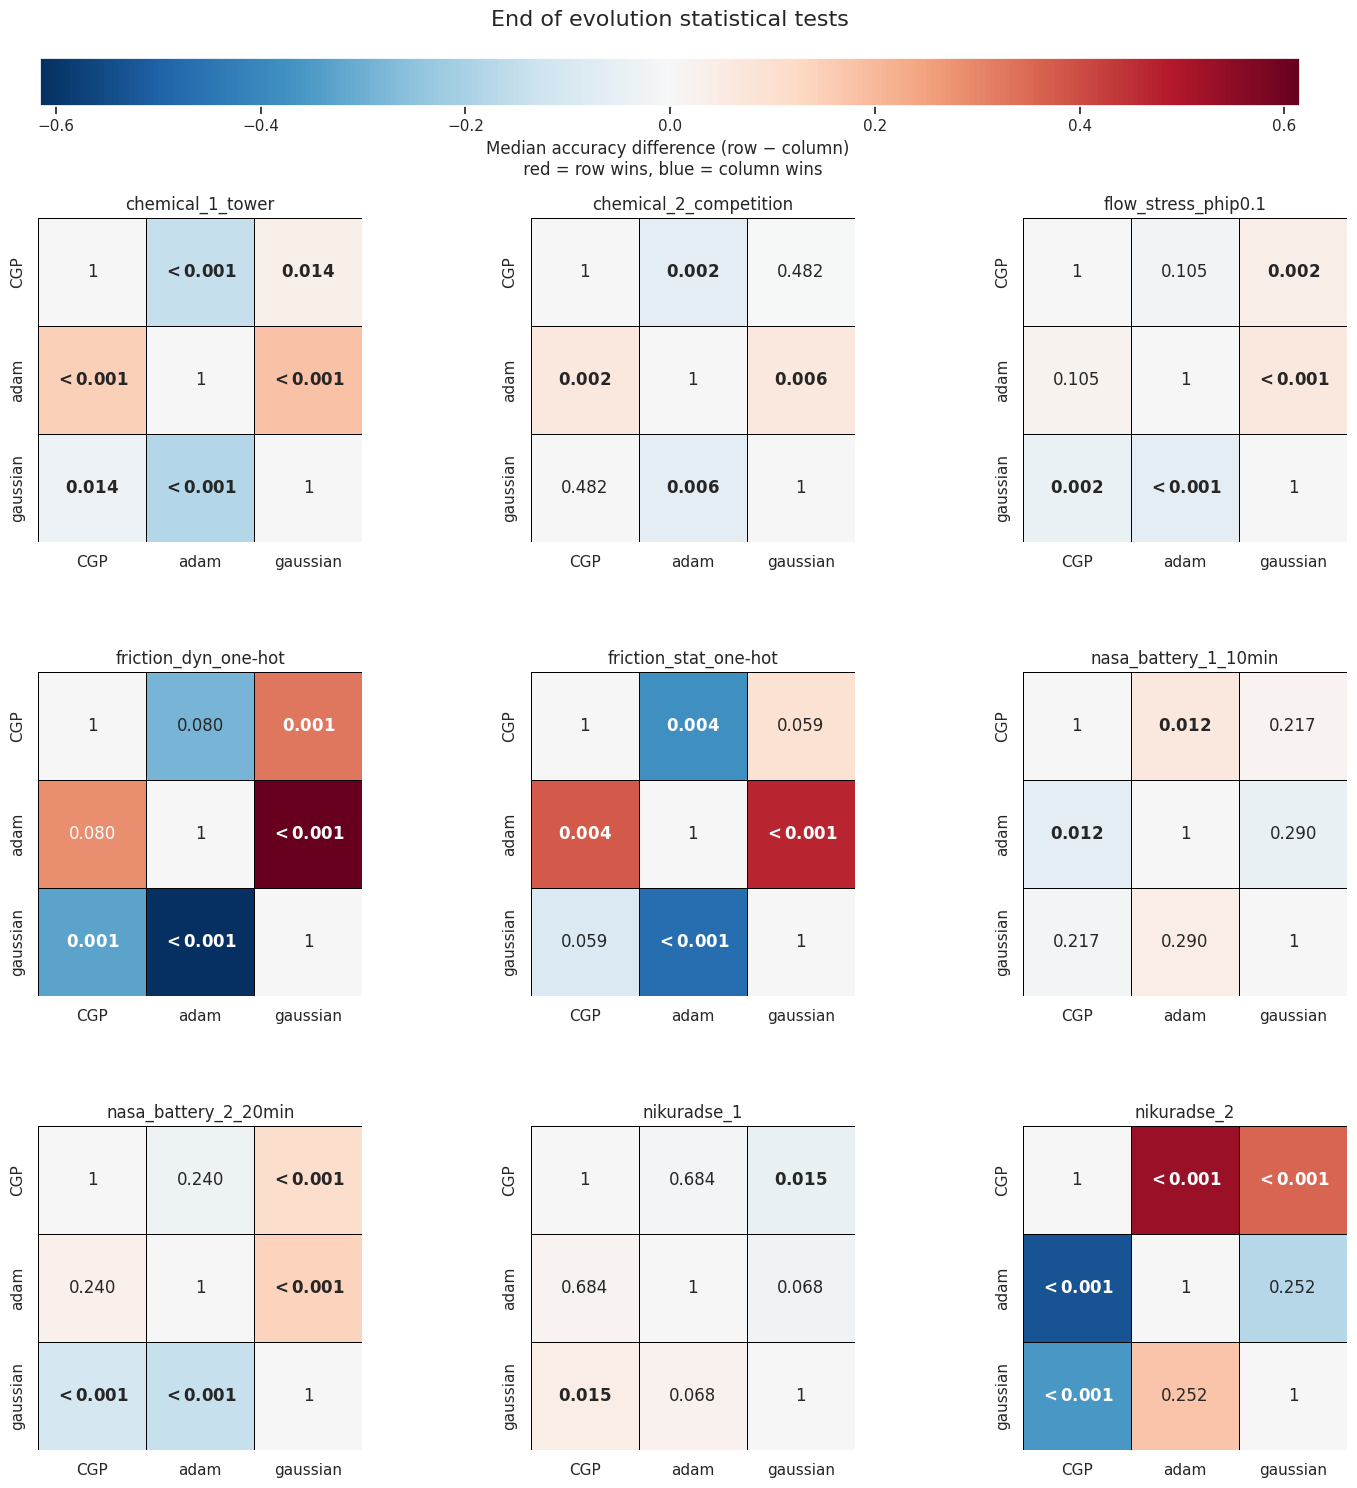

In [21]:
plot_all_problems_3x3_median_diff(pval_tables_final, median_lookup_final, "End of evolution statistical tests",
                                  alpha=0.05 / 3)

In [ ]:
opts_of_interest = ["adam", "CGP"]
alpha = 0.01

for problem, pvals in pval_tables_final.items():
    print(f"\nProblem: {problem}")

    for opt1, opt2 in combinations(opts_of_interest, 2):

        # skip if one opt missing for this problem
        if (problem, opt1) not in median_lookup_final.index or (problem, opt2) not in median_lookup_final.index:
            continue

        p = pvals.loc[opt1, opt2]

        med1 = median_lookup_final.loc[(problem, opt1)]
        med2 = median_lookup_final.loc[(problem, opt2)]

        if p < alpha:
            if med1 > med2:
                winner = opt1
            else:
                winner = opt2

            print(
                f"  {opt1} vs {opt2}: "
                f"WINNER = {winner} "
                f"(p={p:.2e}, Δmedian={med1 - med2:+.4f})"
            )
        else:
            print(
                f"  {opt1} vs {opt2}: "
                f"TIE (p={p:.2e})"
            )

In [ ]:
opts_group = ["adam", "gaussian", "CGP"]
baseline = "Operon"
alpha = 0.05

for problem, pvals in pval_tables_final.items():
    print(f"\nProblem: {problem}")

    # keep only available opts
    available = [
        o for o in opts_group
        if (problem, o) in median_lookup_final.index
    ]

    if (problem, baseline) not in median_lookup_final.index or not available:
        print("  Skipped (missing data)")
        continue

    # find best among adam / gaussian / CGP
    best_opt = max(
        available,
        key=lambda o: median_lookup_final.loc[(problem, o)]
    )

    med_best = median_lookup_final.loc[(problem, best_opt)]
    med_operon = median_lookup_final.loc[(problem, baseline)]

    p = pvals.loc[best_opt, baseline]

    if p < alpha:
        if med_best > med_operon:
            winner = best_opt
        else:
            winner = baseline

        print(
            f"  Best({', '.join(available)}) = {best_opt} vs Operon → "
            f"WINNER = {winner} "
            f"(p={p:.2e}, Δmedian={med_best - med_operon:+.4f})"
        )
    else:
        print(
            f"  Best({', '.join(available)}) = {best_opt} vs Operon → "
            f"TIE (p={p:.2e})"
        )

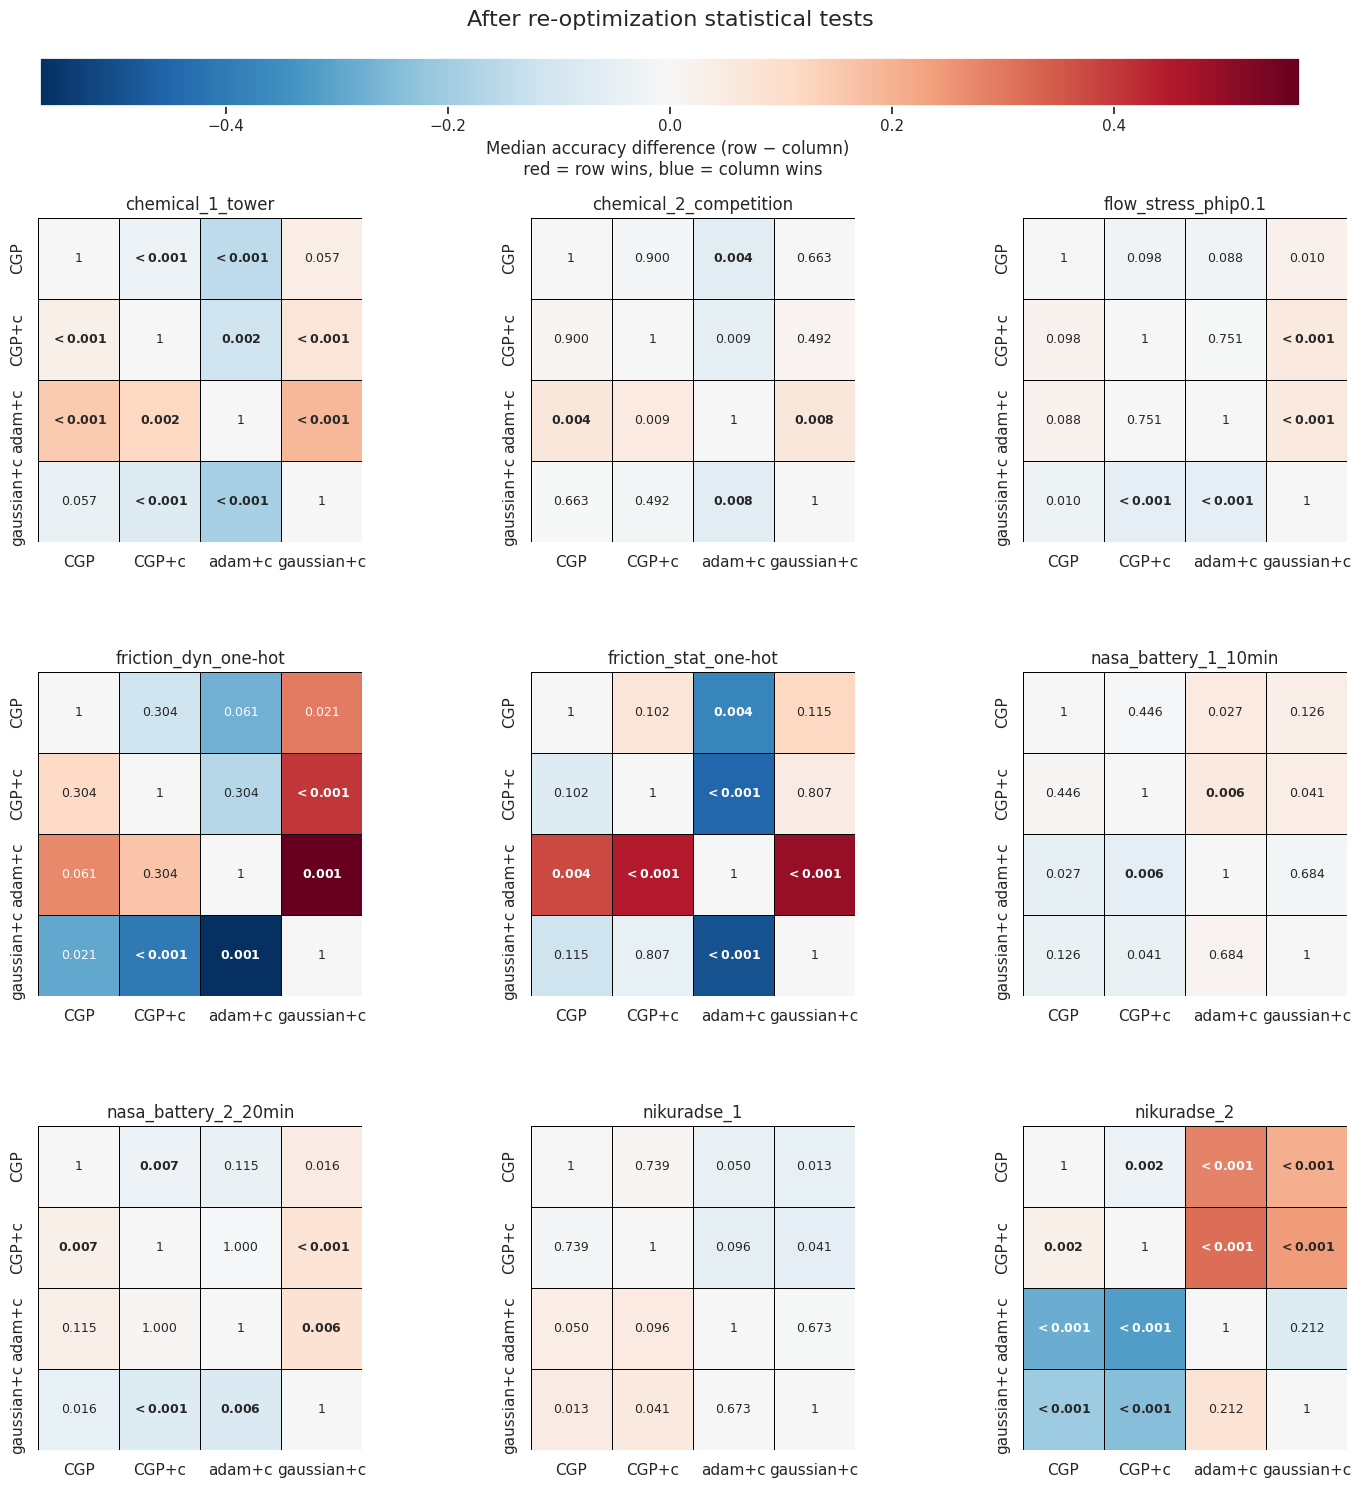

In [34]:
plot_all_problems_3x3_median_diff(pval_tables_reopt, median_lookup_reopt, "After re-optimization statistical tests",
                                  alpha=0.05 / 6)

In [22]:
data_export = False

from statistics import median
from typing import List, Union

from pandas import DataFrame


def line_plot(df: DataFrame, x: str, y: Union[List[str], str], groups: Union[List[str], str] = None,
              file_prefix: str = "", cols_joiner: str = "_", filename_joiner: str = "_"):
    """ Exports data to individual files for line plots with median as main line and shaded area between quartiles.

        Parameters:
        df : dataframe
        x : x-axis column
        y : y-axis column(s)
        groups : grouping variable column(s)
        file_prefix : prefix to prepend to every file generated
        cols_joiner : joiner for columns
        filename_joiner : joiner for file name

       """

    if type(y) == str:
        y = [y]
    if type(groups) == str:
        groups = [groups]

    def q1(a):
        return a.quantile(0.25)

    def q3(b):
        return b.quantile(0.75)

    vals = dict([(key, [q1, q3, median]) for key in y])

    summary = df.groupby(groups + [x]).agg(vals)
    summary.columns = [cols_joiner.join(col) for col in summary.columns.to_flat_index()]
    summary.reset_index(inplace=True)

    key_df = df.drop_duplicates(subset=groups)

    for i in range(len(key_df)):
        tmp = summary
        current_filename = file_prefix
        for key in groups:
            tmp = tmp[tmp[key] == key_df[key].iloc[i]]
            current_filename += f"{filename_joiner if len(current_filename) > 0 and not current_filename.endswith('/') else ''}{key_df[key].iloc[i]}"
        tmp.to_csv(f"{current_filename}.txt", sep="\t", index=False)


def box_plot(df: DataFrame, x: str, y: str, groups: Union[List[str], str] = None, file_prefix: str = "",
             filename_joiner: str = "_"):
    """ Exports data to individual files for box plots.

        Parameters:
        df : dataframe
        x : x-axis column
        y : y-axis column(s)
        groups : grouping variable column(s)
        file_prefix : prefix to prepend to every file generated
        cols_joiner : joiner for columns
        filename_joiner : joiner for file name

       """



In [ ]:
super_final_df["opt_w"] = super_final_df["opt"].astype(str) + "_" + super_final_df["w"].astype(str)
super_final_df.head()

In [ ]:
# reopt_dict = {"Y": "reopt", "N": "evo"}
# for reopt in super_final_df.reopt.unique():
#     for problem in super_final_df.problem.unique():
#         tmp = super_final_df[(super_final_df["reopt"] == reopt) & (super_final_df["problem"] == problem)]
#         wide = tmp.pivot(
#             index="seed",
#             columns="opt_w",
#             values="accuracy"
#         )
#         wide.to_csv(f"../pgfplots/bp_{reopt_dict[reopt]}_{problem}.txt", sep="\t", index=False)

In [ ]:
df_plot

In [ ]:
line_plot(df_plot, x="adjusted_iteration", y="accuracy", groups=["problem", "opt", "w"], file_prefix="../pgfplots/line")

In [31]:
def export_problem_heatmaps(
        pval_tables,
        median_lookup,
        alpha=0.05,
        output_dir="../pgfplots",
        fontsize=10,
        extra="end"
):
    import os
    import matplotlib.pyplot as plt
    from matplotlib import cm, colors
    import seaborn as sns
    import numpy as np

    os.makedirs(output_dir, exist_ok=True)

    global_opt_order = (
        median_lookup
        .groupby("opt")
        .median()
        .sort_values(ascending=False)
        .index
        .tolist()
    )

    problems = list(pval_tables.keys())

    # global symmetric normalization for diverging scale
    max_abs_diff = (
        median_lookup.groupby(level=0)
        .apply(lambda s: (s.max() - s.min()))
        .max()
    )
    norm = colors.TwoSlopeNorm(vmin=-max_abs_diff, vcenter=0, vmax=max_abs_diff)
    cmap = cm.get_cmap("RdBu_r")  # red = worse, blue = better

    print(f"Color scale min: {norm.vmin}, max: {norm.vmax}")

    for problem in problems:
        fig, ax = plt.subplots(figsize=(6, 5))
        ax.set_facecolor("white")

        opts = [o for o in global_opt_order if (problem, o) in median_lookup.index]

        pvals = pval_tables[problem].reindex(index=opts, columns=opts)
        diff = median_diff_matrix(problem, opts, median_lookup)
        annot = np.empty_like(pvals.values, dtype=object)

        for i in range(pvals.shape[0]):
            for j in range(pvals.shape[1]):
                val = pvals.iloc[i, j]

                if np.isnan(val):  # replace NaN with 1
                    annot[i, j] = "1"
                elif val > alpha:
                    annot[i, j] = f"{val:.3f}"
                elif alpha > val >= 0.001:  # bold if significant
                    annot[i, j] = rf"$\mathbf{{{val:.3f}}}$"
                else:
                    annot[i, j] = rf"$\mathbf{{<0.001}}$"

        sns.heatmap(
            diff,
            annot=annot,
            fmt="",
            cmap=cmap,
            norm=norm,
            square=True,
            linewidths=0.5,
            linecolor="black",
            cbar=False,
            ax=ax,
            annot_kws={"fontsize": fontsize}
        )

        # ax.set_title(problem, fontsize=12)

        # remove all axis labels, ticks, and spines
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel("")
        ax.set_ylabel("")
        for spine in ax.spines.values():
            spine.set_visible(False)

        # save figure
        file_path = os.path.join(output_dir, f"heatmap_{extra}_{problem}.pdf")
        print(file_path)
        plt.tight_layout(pad=0)
        plt.savefig(file_path, dpi=300, bbox_inches="tight", pad_inches=0)
        plt.close(fig)  # close the figure to free memory


In [33]:
# export_problem_heatmaps(pval_tables_final, median_lookup_final, alpha=0.05 / 3, fontsize=27, extra="end")
export_problem_heatmaps(pval_tables_reopt, median_lookup_reopt, alpha=0.05 / 6, fontsize=20, extra="reopt")

Color scale min: -0.5671687485, max: 0.5671687485
../pgfplots/heatmap_reopt_chemical_1_tower.pdf
../pgfplots/heatmap_reopt_chemical_2_competition.pdf
../pgfplots/heatmap_reopt_flow_stress_phip0.1.pdf
../pgfplots/heatmap_reopt_friction_dyn_one-hot.pdf
../pgfplots/heatmap_reopt_friction_stat_one-hot.pdf
../pgfplots/heatmap_reopt_nasa_battery_1_10min.pdf
../pgfplots/heatmap_reopt_nasa_battery_2_20min.pdf
../pgfplots/heatmap_reopt_nikuradse_1.pdf
../pgfplots/heatmap_reopt_nikuradse_2.pdf
